In [17]:
results = {
    "MultiEURLEX": {
        "model": { "gemini_1.5":
                       {"clean":    {"en": 0.21, "bg": 0.18, "el": 0.19, "fr": 0.21, "mt": 0.20, "sv": 0.21},
                        "attacked": {},
                        }
                   },
        "legal": True,
    },
    "Eur-Lex-Sum": {
        "model": { "llama":
            {
                "clean":    {"en": 0.18, "de": 0.16, "fr": 0.20, "el": 0.05, "bg": 0.05, "pl": 0.11},
                "attacked": {},
            }
        },
        "legal": True,
    },
    "EUROPA": {
        "model": { "gemini_1.5":
                       {"clean":    {"en": 3.77, "el": 3.32, "bg": 3.76, "mt": 3.79, "fr": 3.50, "sv": 3.70},
                        "attacked": {},
                        }
                   },
        "legal": True,
    },
    "ToS": {
        "model": { "gemini_1.5":
                       {"clean":    {"en": 0.66, "de": 0.63, "it": 0.61, "pl": 0.65},
                        "attacked": {},
                        }
                   },
        "legal": True,
    },
    "LEXam-MC": {
        "model": { "gemini_1.5":
                       {"clean":    {"en": 0.48, "de": 0.40},
                        "attacked": {"en": 0.38, "de": 0.34},
                        },
                   "gemini_2.5":
                       {"clean":    {"en": 0.74, "de": 0.51},
                        "attacked": {"char_attack": {"en": 0.74, "de": 0.47},
                                     "word_attack": {"en": 0.50, "de": 0.43},}
                        }
                   },
        "legal": True,
    },
    "LEXam-Open": {
        "model": { "gemini_1.5":
                       {"clean":    {"en": 3.71, "de": 2.77},
                        "attacked": {"en": 2.93, "de": 2.21},
                        },
                   "gemini_2.5":
                       {"clean":    {"en": 4.14, "de": 3.62},
                        "attacked": {"char_attack": {"en": 4.02, "de": 3.19},
                                     "word_attack": {"en": 3.28, "de": 2.47},}
                        }
                   },
        "legal": True,
    },
    "XNLI": {
        "model": { "gemini_1.5":
                       {"clean":    {"en": 0.73, "el": 0.70, "bg": 0.67, "es": 0.73, "fr": 0.69, "th": 0.56},
                        "attacked": {"en": 0.44, "el": 0.46, "bg": 0.43, "es": 0.47, "fr": 0.46, "th": 0.46},
                        },
                   "llama":
                       {"clean":    {"en": 0.52, "el": 0.45, "bg": 0.47, "es": 0.41, "fr": 0.43, "th": 0.34},
                        "attacked": {}},
                   },
        "legal": False,
    },
    "XQuAD": {
        "model": { "gemini_1.5":
                       {"clean":    {"en": 4.94, "el": 4.73, "ar": 4.67, "zh": 4.68, "ru": 4.78, "th": 4.74, "tr": 4.61},
                        "attacked": {"en": 3.88, "el": 3.88, "ar": 3.71, "zh": 3.96, "ru": 3.92, "th": 4.13, "tr": 3.52},
                        }
                   },
        "legal": False,
    },
}

# Creates plot with aggregated results per language (per task using zscore normalization and over all tasks using minmax)

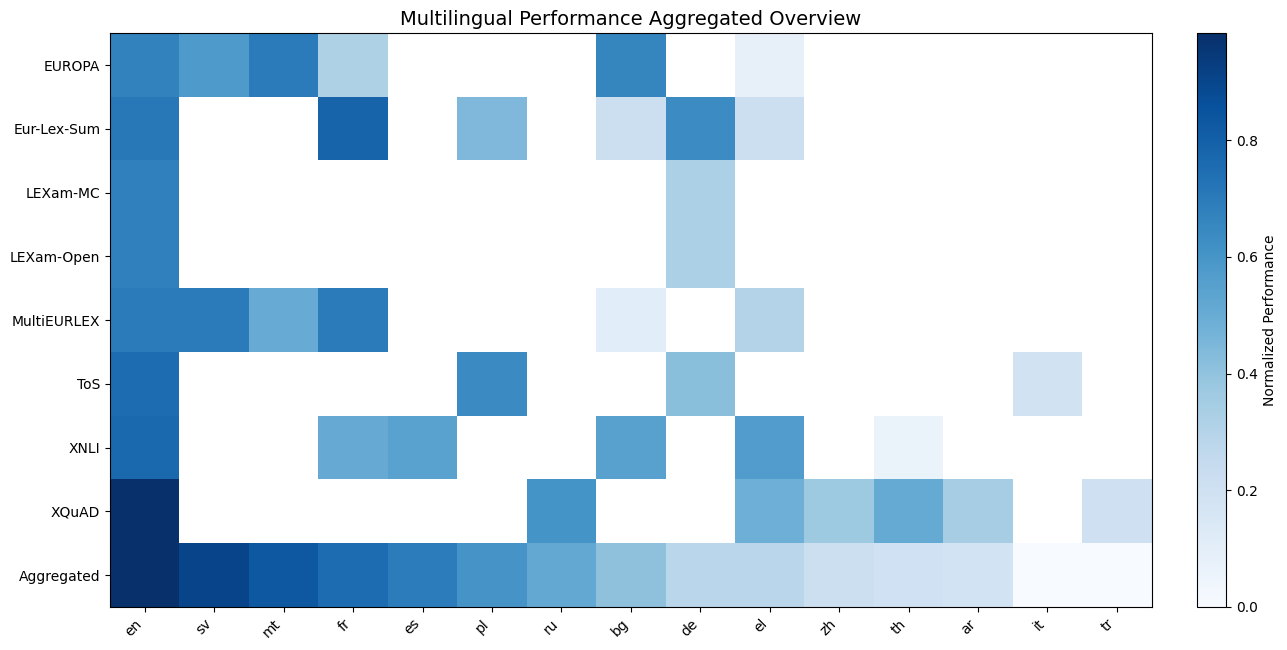

Saved combined heatmap to: ./aggregated\combined_heatmap_20250914_212248.pdf


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, datetime

def minmax_normalize(s: pd.Series) -> pd.Series:
    vmin, vmax = s.min(skipna=True), s.max(skipna=True)
    if pd.isna(vmin) or pd.isna(vmax) or vmax == vmin:
        return s.apply(lambda x: np.nan if pd.isna(x) else 0.5)
    return (s - vmin) / (vmax - vmin)

def zscore_normalize(s: pd.Series, clip: float = 2.0) -> pd.Series:
    mu, sd = s.mean(skipna=True), s.std(skipna=True)
    if pd.isna(mu) or pd.isna(sd) or sd == 0:
        z = s.apply(lambda x: np.nan if pd.isna(x) else 0.0)
    else:
        z = (s - mu) / sd
    z = z.clip(-clip, clip)
    return (z + clip) / (2 * clip)

def build_dataset_tables(results, language_order, model_order=None, clip=2.0):
    # Collect raw clean scores per dataset per language per model
    datasets = []
    for dname, dpayload in results.items():
        if "model" not in dpayload:
            continue
        for mname, mpayload in dpayload["model"].items():
            if "clean" not in mpayload:
                continue
            row = pd.Series(mpayload["clean"], name=(dname, mname))
            datasets.append(row)
    df_raw = pd.DataFrame(datasets).fillna(np.nan)

    # Z-score normalization (per dataset+model row)
    df_z = df_raw.apply(zscore_normalize, axis=1)

    # Min–max normalization (per dataset+model row)
    df_mm = df_raw.apply(minmax_normalize, axis=1)

    # Average over models per dataset (after min–max)
    df_mm_avg = df_mm.groupby(level=0).mean()

    # Aggregated score across datasets
    agg_scores = df_mm_avg.mean(axis=0)

    # Build combined heatmap (datasets + aggregate row)
    combined = pd.concat([df_z.groupby(level=0).mean(), agg_scores.to_frame().T])
    combined.index = list(df_z.groupby(level=0).mean().index) + ["Aggregated"]

    # Reorder languages by aggregated score
    sorted_langs = agg_scores.sort_values(ascending=False).index.tolist()
    combined = combined[sorted_langs]

    return combined

def plot_combined_heatmap(combined: pd.DataFrame, title="Multilingual Performance Overview", out_dir="./aggregated"):
    os.makedirs(out_dir, exist_ok=True)
    timestamp = datetime.datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    out_path = os.path.join(out_dir, f"combined_heatmap_{timestamp}.pdf")

    plt.figure(figsize=(0.6*combined.shape[1]+4, 0.4*combined.shape[0]+3))
    im = plt.imshow(combined.values, aspect="auto", cmap="Blues", interpolation="nearest")

    plt.colorbar(im, fraction=0.046, pad=0.04, label="Normalized Performance")
    plt.xticks(range(combined.shape[1]), combined.columns, rotation=45, ha="right")
    plt.yticks(range(combined.shape[0]), combined.index)
    plt.title(title, fontsize=14)
    plt.tight_layout()

    # Save and also show
    plt.savefig(out_path, format="pdf")
    plt.show()

    print(f"Saved combined heatmap to: {out_path}")
    
languages = ["en","bg","el","fr","mt","sv","de","it","pl","es","th","ar","zh","ru","tr"]

combined = build_dataset_tables(results, language_order=languages, clip=2.0)
plot_combined_heatmap(combined, title="Multilingual Performance Aggregated Overview", out_dir="./aggregated")


## Creates Plot for Similarity to English vs Aggregated Score for Gemini 1.5-Flash

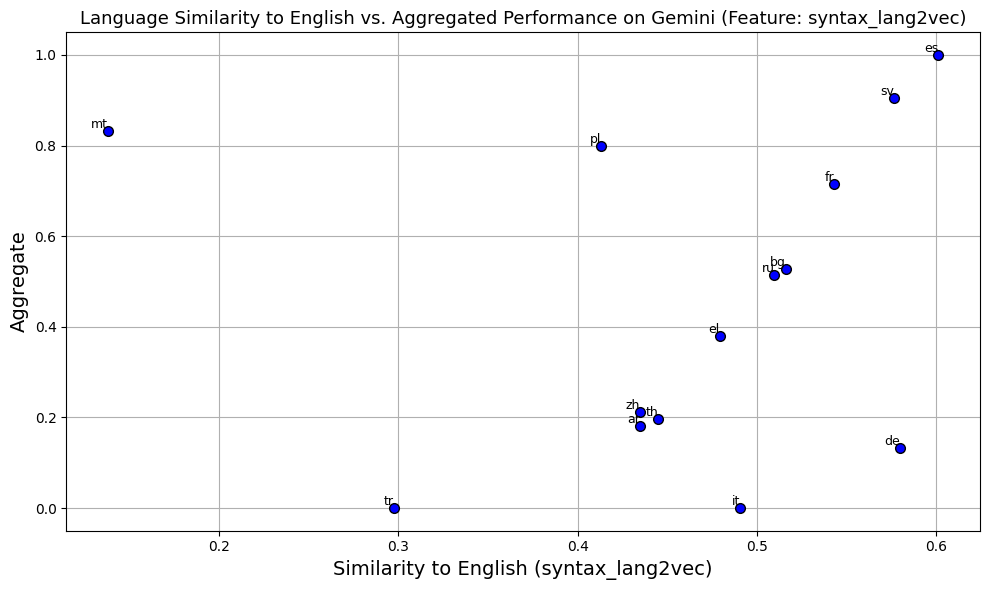

Saved: ./aggregated/overview\Aggregate_vs_similarity_syntax_lang2vec_20250914_193541.pdf


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
from typing import Dict, Any, Optional, Iterable

# -------------------------------
# ISO 639-1 → ISO 639-3
# -------------------------------
iso2_to_iso3 = {
    'en':'eng','bg':'bul','el':'ell','fr':'fra','mt':'mlt','sv':'swe',
    'de':'deu','it':'ita','es':'spa','th':'tha','ar':'ara','zh':'zho',
    'ru':'rus','tr':'tur','pl':'pol','ro':'ron','nl':'nld','cs':'ces',
    'da':'dan','fi':'fin','hu':'hun','pt':'por','sk':'slk','sl':'slv',
}

# -------------------------------
# Min-Max Normalization
# -------------------------------
def _normalize_series_minmax(s: pd.Series) -> pd.Series:
    vmin, vmax = s.min(skipna=True), s.max(skipna=True)
    if pd.isna(vmin) or pd.isna(vmax) or vmax == vmin:
        return s.apply(lambda x: np.nan if pd.isna(x) else 0.5)
    return (s - vmin) / (vmax - vmin)

def _normalize_df_minmax(df: pd.DataFrame) -> pd.DataFrame:
    return df.apply(_normalize_series_minmax, axis=1)

# -------------------------------
# Build overview for a model
# -------------------------------
def build_overview_for_model(
        results: Dict[str, Dict[str, Any]],
        model_name: str,
        language_order: Optional[Iterable[str]] = None,
        dataset_order: Optional[Iterable[str]] = None,
) -> Dict[str, Any]:
    datasets_all = [d for d, payload in results.items() if "model" in payload and model_name in payload["model"]]
    datasets = [d for d in (dataset_order or datasets_all) if d in datasets_all]

    langs = set()
    for d in datasets:
        entry = results[d]["model"][model_name]
        langs.update(entry.get("clean", {}).keys())

    languages = [l for l in (language_order or sorted(langs)) if l in langs]

    clean_df = pd.DataFrame(index=datasets, columns=languages, dtype=float)

    for d in datasets:
        entry = results[d]["model"][model_name]
        for l, v in entry.get("clean", {}).items():
            clean_df.loc[d, l] = v

    clean_norm = _normalize_df_minmax(clean_df)
    lang_agg_clean = clean_norm.mean(axis=0, skipna=True)

    return {
        "clean_df_raw": clean_df,
        "clean_df_norm": clean_norm,
        "lang_agg_clean": lang_agg_clean,
    }

# -------------------------------
# Similarity functions
# -------------------------------
def load_similarity_to_english(feature_file: str, use_precomputed: bool = True) -> pd.DataFrame:
    """
    Returns a DataFrame with columns: iso3, similarity
    where similarity = 1 - distance(lang, eng).
    """
    if use_precomputed:
        df_wide = pd.read_csv(feature_file)
        df_wide = df_wide.rename(columns={df_wide.columns[0]: 'lang1'})
        df_long = df_wide.melt(id_vars='lang1', var_name='lang2', value_name='distance')
        eng_df = df_long[(df_long['lang1'] == 'eng') & (df_long['lang2'] != 'eng')].copy()
        eng_df['similarity'] = 1.0 - eng_df['distance']
        eng_df['iso3'] = eng_df['lang2']
        return eng_df[['iso3','similarity']].dropna()
    else:
        df = pd.read_csv(feature_file)
        df = df.rename(columns={'language_1':'lang1','language_2':'lang2'})
        eng_df = df[
            ((df['lang1'] == 'eng') & (df['lang2'] != 'eng')) |
            ((df['lang2'] == 'eng') & (df['lang1'] != 'eng'))
            ].copy()
        eng_df['iso3'] = eng_df.apply(lambda r: r['lang2'] if r['lang1']=='eng' else r['lang1'], axis=1)
        return eng_df[['iso3','similarity']].dropna()

def plot_similarity_vs_aggregate(
        similarity_df: pd.DataFrame,
        aggregate_df: pd.DataFrame,
        feature_name: str,
        metric_name: str = "Aggregate",
        title_prefix: str = "Similarity vs. Aggregated Performance",
        out_dir: str = "./aggregated"
):
    merged = similarity_df.merge(aggregate_df, on='iso3', how='inner')
    if merged.empty:
        print("No overlap between similarity languages and aggregate languages.")
        return

    os.makedirs(out_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    plt.figure(figsize=(10,6))
    plt.errorbar(
        merged['similarity'], merged[metric_name],
        fmt='o', markerfacecolor='blue', markeredgecolor='black', markersize=7
    )
    for _, row in merged.iterrows():
        plt.text(row['similarity'], row[metric_name], row['language'], fontsize=9, ha='right', va='bottom')

    plt.xlabel(f"Similarity to English ({feature_name})", fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.title(f"{title_prefix} (Feature: {feature_name})", fontsize=13)
    plt.grid(True)
    plt.tight_layout()

    out_path = os.path.join(out_dir, f"{metric_name}_vs_similarity_{feature_name}_{timestamp}.pdf")
    plt.savefig(out_path, format='pdf')
    plt.show()
    print(f"Saved: {out_path}")


if __name__ == "__main__":

    languages_15 = ["en","bg","el","fr","mt","sv","de","it","es","th","ar","zh","ru","tr","pl"]

    out = build_overview_for_model(results, model_name="gemini_1.5", language_order=languages_15)

    # Aggregate
    s = out["lang_agg_clean"]
    agg_df = s.rename("Aggregate").reset_index().rename(columns={'index':'language'})
    agg_df = agg_df[agg_df['language'].isin(languages_15)]
    agg_df['iso3'] = agg_df['language'].map(iso2_to_iso3)
    agg_df = agg_df[['language','iso3','Aggregate']].dropna()

    # Similarity
    distance_root = "../../data/language_similarity/lang2vec/distances"
    feature_files = {
        "syntax_lang2vec": f"{distance_root}/SYNTACTIC.csv",
    }

    for feat, path in feature_files.items():
        if not os.path.exists(path):
            print(f"Missing: {path}")
            continue
        sim_df = load_similarity_to_english(path, use_precomputed=True)
        plot_similarity_vs_aggregate(
            similarity_df=sim_df,
            aggregate_df=agg_df,
            feature_name=feat,
            metric_name="Aggregate",
            title_prefix="Language Similarity to English vs. Aggregated Performance on Gemini"
        )
